# Library Imports

In [ ]:
#connect to google sheets
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

#fuzzywuzzy
!pip install fuzzywuzzy[speedup]
from fuzzywuzzy import fuzz

#google translate
!pip install googletrans
from googletrans import Translator
tr = Translator()

import statistics as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

#for nlp + visualisation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm      as cm
import seaborn            as sns
from wordcloud import WordCloud

!pip install wikipedia
import wikipedia

from IPython.display import clear_output
clear_output()

## Data Imports

In [ ]:
sh2 = 'https://docs.google.com/spreadsheets/d/1zit8jJhj7ccbX9P4iiXaW3Fxs5ITrEaZ6UZCw9isEAQ/'       #id of spreadsheet with key products
ws2 = 'DB_KeyProd'                #worksheet with list
row2 = 5
col21 = 'Key Product'                       #column with key products
col22 = 'Keywords'                       #column with key words

# Import the MAIA data from google sheets
wb = gc.open_by_url(sh2)
sheet = wb.worksheet(ws2)
df2 = pd.DataFrame(sheet.get_all_values(),columns=sheet.row_values(row2)).iloc[row2:].reset_index(drop=True)

df_key = df2[[col21,col22]].reset_index(drop=True)
df_key.columns = ['key_product','keywords','keyword_count']
df_key["keywords"]=df_key["keywords"].str.split(";")

def append_keyprod(x):
  x["keywords"].append(x["key_product"])
  return x

df_key = df_key.apply(append_keyprod,axis=1) 

def remove_blank(x):
  x['keywords'] = list(filter(None, x['keywords']))
  return x

df_key = df_key.apply(remove_blank, axis=1)

In [ ]:
#dutch categories from bol.com
sh3 = 'https://docs.google.com/spreadsheets/d/1c4bU3rvXPw4EWLRag1_Vl6H2DS05qfHMXD9Jr6vHUOI/'       #id of spreadsheet with key products
ws3 = 'Scraper'                #worksheet with list
row3 = 1
col3 = 'Category'                       #column with categories

wb = gc.open_by_url(sh3)
sheet = wb.worksheet(ws3)
df3 = pd.DataFrame(sheet.get_all_values(),columns=sheet.row_values(row3)).iloc[row3:].reset_index(drop=True)

df_cat = df3[[col3]].reset_index(drop=True)

df_cat.columns = ['categories']

#replace '&amp;' (which screws up translation) with '&'
for i,r in df_cat.iterrows():
  r['categories'] = r['categories'].replace('&amp;', '&')

df_cat['en'] = ''



## Translate function

In [ ]:
#function to translate df column
def col_translator(df, column, src, dest):
  #df: dataframe
  #column: column name of interest
  #src: source language, 'nl' or 'en'
  #dest: destination language, 'en' or 'nl'
  trlist =[]
  for i,r in df.iterrows():
    new = tr.translate(r[column], src=src, dest=dest).text
    r['en'] = new
    trlist.append(new)

  return df, trlist

## Translated categories

In [ ]:
start = time.time()
df_cat, trlist = col_translator(df_cat, 'categories', 'nl','en')
end = time.time()
print('first translation time = ', end-start)

#for some reason the translation skips some lines so !!!
start = time.time()
for i,r in df_cat.iterrows():
  if r['categories'] == r['en']:
    r['en'] = tr.translate(r['categories'], src='nl', dest='en').text
end = time.time()
print('second translation time = ', end-start)



first translation time =  154.43560981750488
second translation time =  148.09175753593445


## Keyword Corpus

In [ ]:
#create corpus as list of strings of keyword sets 
def lister(x):
  y = ''
  for i in x['keywords']:
    y = y+i+'; '
  x['doc'] = y
  return x

df_key = df_key.apply(lister, axis=1)

corpus_key = list(df_key['doc'])

#walmart products corpus
# keywords = [['SNICKERS, TWIX, 3 MUSKETEERS, MILKY WAY & MILKY WAY Midnight Chocolate Candy, Halloween MINIS, 135 pieces, 40 oz bag chocolate', "Hershey's, Full Size Candy Bars Variety Pack, 18 Ct. chocolate", "Hershey's, Snack Size Chocolate Assortment Candy, 35.04 Oz chocolate", 'SNICKERS, TWIX, 3 MUSKETEERS & MILKY WAY Chocolate Candy, Halloween Full Size, 18 pieces, 33.31 oz box chocolate', 'York, Peppermint Patties Dark Chocolate Candy Party Pack, 35.2 Oz. chocolate', "M&M'S Peanut Butter Chocolate Candy Party Size, 34 oz chocolate", "M&M'S Peanut Chocolate Candy, 38-Ounce Party Size Bag chocolate", "M&M'S Milk Chocolate Candies, party size, 38 oz. chocolate", "Hershey's Kisses, Milk Chocolate Candy, 35.8 Oz. chocolate", "Hershey's, Snack Size Chocolate Assortment Candy, 33.43 Oz. chocolate"], ['Creative Stationery Metal tape Holder Tape Cutter Of Life Office Tape Dispenser tape holder', 'JAM Desk Trio Pack, Grey, Stapler, Tape Dispenser & Pen Holder, 3/Pack tape holder', 'Juslike Tape Dispenser, Heavy Duty Tape Dispenser Desk Tape Dispensers 1 Inch Core, for 1/2 or 3/4 Inch Magic Tape Invisible Tape, Non-Slip One-Hand Tape Holder, 2 Pack tape holder', 'Scotch Desktop Tape Dispenser, Two-Toned Black tape holder', 'Peroptimist Heavy Duty Tape Dispenser Desk Tape Dispensers 1 Inch Core, Office Desktop Tape Dispenser for 1/2 or 3/4 Inch Magic Tape Invisible Tape, Non-Slip One-Hand Tape Holder, 2 Pack tape holder', 'Adhesive Tape Dispenser Office Desktop Paper Stationery Masking Tape Holder Storage Organizer Dispenser tape holder', 'Emraw 1 Core Desktop Tape Dispenser for Office Non-Slip Home One-Hand Tape Holder Blade Non-Skid Base Transparent Tape Dispenser Black School Supplies (Pack of 3) tape holder', 'Mini 1" Core Desktop Tape Dispenser with Tape Refills Non-Slip Home One Hand Tape Holder Blade Non-Skid Base Transparent Tape Dispenser School Supplies (Pack of 2) by - Emraw tape holder'], ['HP Pavilion 15.6", Intel Core i5, 8GB RAM, 512GB SSB+32GB Optane, Lunar Gold laptop', 'Lenovo ideapad S540 14.0" Touch Laptop, Intel Core i5-10210U Quad-Core Processor, 8GB Memory, 256GB Solid State Drive, Windows 10 - Mineral Grey - 81V00001US (Google Classroom Compatible) laptop', 'Asus VivoBook 14" FHD Thin and Light Laptop, AMD Ryzen 5 3500U Processor, 8GB RAM, 256GB SSD Storage, Windows 10 (Google Classroom Compatible) laptop', 'Lenovo ideapad S340 13.3 Laptop, Intel Core i5-10210U Quad-Core Processor, 8GB Memory, 256GB Solid State Drive (Google Classroom Compatible) laptop', 'EVOO 11.6" Convertible Touchscreen Laptop - Elite Series, Windows 10 S, Windows Hello (Fingerprint Scanner), Windows Ink, (Smart Stylus Included), Cortana, Micro HDMI, Black laptop', 'ASUS ROG Zephyrus G Ultra Slim Gaming Laptop, 15.6” IPS Type FHD, GeForceGTX 1660 Ti, AMD Ryzen 7 3750H, 8GB DDR4, 512GB PCIeNVMe SSD, Windows 10,GA502GU-PB73 laptop', 'EVOO Gaming Laptop 15" FHD 144Hz Display, THX Spatial Audio, Tuned by THX Display, 9th Gen Intel i7-9750H, Nvidia GTX 1650, 256GB SSD, 16GB Memory, Windows 10 Home, Black laptop', 'Acer Spin 3, 2-in-1 Laptop, 14" Full HD IPS Touch, 10th Gen Intel Core i7-1065G7, 8GB RAM, 512GB SSD, Rechargeable Active Stylus, SP314-54N-77L5 (Google Classroom Compatible) laptop', 'Acer Swift 3 Laptop, 14" Full HD 1080p, AMD Ryzen 5 4500U Hexa-Core Processor, 8GB RAM, 256GB SSD, Fingerprint Reader, Back-lit Keyboard, Windows 10 Home, SF314-42-R0HP laptop', 'HP Envy 13.3" Full HD, Intel Core i5-1035G1, Intel UHD Graphics, 8GB SDRAM, 256GB SSD, Natural Silver, Windows 10, 13-ba0047wm (Google Classroom Compatible) laptop'], ['Rayovac Recharge NiMh, AAA Batteries, 4 Count rechargeable battery', 'Energizer Rechargeable 850mAh AAA Batteries (4 Pack) rechargeable battery', 'Duracell ION SPEED 1000 Rechargeable Battery Charger for AA and AAA, Includes 4 AA NiMH Batteries rechargeable battery', 'Rayovac Rechargeable AA Batteries, Ready to Use NiMh, 8 Count rechargeable battery', 'Energizer Recharge Power Plus Rechargeable AA Batteries, 8 Pack rechargeable battery', 'Rayovac Rechargeable AA Batteries, Double A Battery 4 Count rechargeable battery', 'Energizer Recharge Value Charger rechargeable battery', 'Duracell 1.2V Rechargeable NiMH AA Batteries 4 Pack rechargeable battery', '20 AA Rechargeable Batteries NiMH 600mAh 1.2v Garden Solar Ni-Mh Light LED C20 rechargeable battery', 'Energizer Recharge Pro AA & AAA Battery Charger, Includes 4 Rechargeable NiMH AA Batteries rechargeable battery'], ['Kodak 223 Lithium Disposable Battery, 6 Volts disposable battery', 'Energizer Ultimate Lithium Long Lasting Leakproof Disposable Batteries disposable battery', 'MixBin Ready to Use, Disposable Battery Power Bank for Smartphones _ Retail Packaging _ Instant Power 3 Pack disposable battery', 'McKesson 81389600 Disposable Alkaline Battery&#44; 9V Cell 9V - Pack of 10 disposable battery', 'McKesson 76379600 Disposable Alkaline Battery&#44; AA Cell 1.5V - Pack of 24 disposable battery', 'Viatek Renu - It Disposable Battery Regenerator disposable battery', 'Duracell Zinc Air Battery  675 Cell 1.4V Disposable Box of 36 disposable battery', 'Battarix Portable Thin and Compact Disposable  Emergency Quick Battery Charger disposable battery', 'MixBin Ready to Use, Disposable Battery Power Bank for Smartphones _ Retail Packaging _ Instant Power 1 Pack disposable battery', 'Duracell Coppertop Alkaline Battery  C Cell 1.5V Disposable, 12 Pack disposable battery'], ['DaySpring  -  Candace Cameron Bure - Inpowered - 2020-2021 18-Month Agenda Planner agenda', 'DaySpring  -  Floral & Stripes - 2020-2021 Planner - Academic Weekly & Monthly Agenda Planner with Tabs, Interior Pocket and Note Pages agenda', 'Middle / High School Planner 2020-2021 (Block Style - 5.5"x8.5" - Black Brick) - SC20-SB-5585-C1 agenda', 'Daily Planner 2020 Weekly And Monthly Academic Planner To Achieve Your Goals And Improve Productivity, A5/A6 Agenda Planner For Children And Adults 98 Sheets agenda', 'Middle / High School Planner 2020-2021 (Matrix Style - 8.5"x11" - Blue) - SC20-SM-8511-C1 agenda', 'Simplified for AT-A-GLANCE Academic Weekly/Monthly Planner, July Start, 6" x 8", Gold Stripe (ELW20-201A-21) agenda', 'Middle / High School Planner 2020-2021 (Matrix Style - 5.5"x8.5" - Blue) - SC20-SM-5585-C1 agenda', 'DaySpring  -  Sadie Robertson - Live Original - 2020-2021 18-Month Agenda Planner agenda', 'DaySpring  -  Something New - 2020-2021 Planner - Academic Weekly & Monthly Agenda Planner with Tabs, Interior Pocket and Note Pages agenda', 'Simplified for AT-A-GLANCE Academic Weekly/Monthly Planner, July Start, 9" x 11", Happy Stripe (ELW20-901A-21) agenda'], ['Universal Business Envelope, #10, 4 1/8 x 9 1/2, White, 500/Box envelope', 'Blue Summit Supplies 500 #10 Gummed Double Window Security Envelopes-Perfect Size for Multiple Business Statements, Quickbooks Invoices, and Return Envelopes -4 1/8 X 9 ½ envelope', 'Mead #10 Security Envelopes, White, 40 pack envelope', 'Mead Press-It Seal-It #6 3/4 Security Envelopes White #6 3/4 (75030) envelope', 'Blue Summit Supplies 500 #10 Flip and Seal Double Window Security Envelopes-Perfect Size for Multiple Business Statements, Quickbooks Invoices, and Return Envelopes -4 1/8 X 9 ½ envelope', 'Mead #10 Press-It Seal-It® Security Envelopes, 4 1/4" x 9 1/2", White, 45 Count (75026) envelope', 'Mead #6 Envelopes, 3 5/8" x 6 1/2", White, 100 Count (75100) envelope', 'Pen+Gear Privacy Tint Business Envelopes, 20 lb. White, #10 (4-1/8 X 9-1/2 in.), Peel & Stick, 40-Count envelope', 'Universal Peel Seal Strip #10 Security Business Envelope 100/Box envelope', 'Quality Park Clasp Envelopes, 28 lb. Brown Kraft, (9 x 12 in.), Gummed, 100-Count envelope'], ['(4 Pack) Mead Junior Legal Pad, 5" x 8", Canary Yellow notepad', 'Universal Colored Perforated Note Pads, Narrow Rule, 5 x 8, Orchid, 50 Sheet, Dozen notepad', 'TOPS Prism Writing Pads, Jr. Legal Rule, Assorted Colors, 5 x 8 in., 50 Sheets notepad', 'TOPS The Legal Pads, 12 Pack, Legal Rule, Perforated, 50 Sheets, 8-1/2" x 11-3/4", Canary (7532) notepad', 'juvale to-do-list notepad - 12-pack magnetic notepads, grocery list magnet memo pad for shopping, to do list, reminders, house chores, 6 colors and designs, 60 sheets per pad, 3.5 x 9 inches notepad', 'TOPS The Legal Pad Writing Pads 12 Pack , Legal Rule, 50 Sheets, 8-1/2 in. x 11-3/4 in., White (7533) notepad', 'Religious notepad - 12 Pack Magnetic Notepads, To-Do-List, Grocery List, Religious Gifts, 12 Faith Designs, Scripture Prayer Notepads, 55 Sheets Per Pad, 2.75 x 6.25 Inches notepad', 'Universal Premium Ruled Writing Pads, Wide/Legal Rule, 8.5 x 11, White, 50 Sheets, 6/Pack -UNV30630 notepad', 'Ampad Mead Legal Ruled Pad, 8 1/2 x 11, White, 50 Sheets, 4 Pads/Pack notepad', 'Universal Perforated Writing Pads, Wide/Legal Rule, 8.5 x 11.75, White, 50 Sheets, Dozen -UNV20630 notepad'], ['Light Pink Tissue Paper, 15"x20", 100 ct tissue paper', 'Cottonelle Ultra CleanCare Strong Toilet Paper, 12 Mega Rolls, Bath Tissue tissue paper', 'Antique Gold Tissue Paper, 15"x20", 100 ct tissue paper', 'Scott ComfortPlus Toilet Paper, 24 Mega Rolls tissue paper', 'Red Tissue Paper, 15"x20", 100 ct tissue paper', 'Lime Green Tissue Paper, 20"x30", 48ct tissue paper', 'Scott Rapid-Dissolving Toilet Paper, 8 Rolls, Bath Tissue for RV & Boats tissue paper', 'Tissue Paper Sheets, 26 x 20 in, Teal, 10ct tissue paper', 'White Tissue Paper, 15"x20", 100 ct tissue paper', 'American Greetings White Tissue Paper, 125-Sheets tissue paper']]
# corpus_wal = [item for sublist in keywords for item in sublist]

## Web Text Corpus

In [ ]:
pannekoek1 = "Zeef de bloem met het zout boven een grote beslagkom. Voeg de eieren en de helft van de melk toe en klop met een garde tot een glad beslag. Schenk de rest van de melk erbij en klop opnieuw glad. Dek de kom af met vershoudfolie en laat het beslag 30 min. staan. Verhit een klontje boter in een koekenpan van 20 cm doorsnee en schep er een soeplepel beslag in. Draai de pan rond zodat de hele bodem bedekt is. Laat de pannenkoek 2 min. op middelhoog vuur bakken tot de bovenkant droog is en de onderkant goudbruin. Draai de pannenkoek om en bak nog 1 min. Herhaal met de rest van het beslag. Houd de pannenkoeken warm onder een deksel of een bord tot al het beslag gebruikt is."
pannekoek2 = "Schep de bloem in een kom en maak een kuiltje in de bloem. Schenk een beetje melk in het kuiltje en voeg de eieren toe en roer dit met een garde tot een glad mengsel en voeg vervolgens de rest van de melk toe. Breng op smaak met een snufje zout. Verwarm een pan en bak het spek knapperig. Voeg hier een pollepel beslag aan toe en beweeg de pan zodat de hele bodem bedekt is. Maak na circa 2 minuten de kantjes los en draai de pannenkoek om. Strooi er kaas naar smaak overheen en bak ook deze kant circa 2 minuten."
pasta1 = "Pasta is een van de makkelijkste en meest veelzijdige gerechten die u kunt bereiden. U kunt het gerecht maken met tomatensaus, roomsaus, olijfolie et cetera. Ook kunt u een salade maken of juist een omelet. Kortom; iedereen kan een pasta bereiden naar eigen smaak. Hier vindt u dan ook veel verschillende recepten die u kunt gebruiken. Ook de pasta zelf kunt u naar eigen smaak aanpassen. U kunt namelijk kiezen voor spaghetti, penne of juist tortellini die gevuld kan worden met kaas of vlees. Het voordeel van pasta is het gemak en de bereidingstijd; het duurt niet lang om een pasta te bereiden. Ook kost het vaak niet veel om een pasta te maken en kunnen er veel groenten worden toegevoegd waardoor u genoeg vitaminen binnen krijgt."
pasta2 = "Snijd de kipfilet in blokjes. Borstel de champignons schoon en snijd in vieren. Snijd de zon-gedroogde tomaten in dunne reepjes en ontdooi de spinazie volgens de bereidingswijze op de verpakking. Kook de pasta beetgaar volgens de aanwijzingen op de verpakking. Verwarm een wok met een scheutje olie en bak de kipfilet blokjes bruin op hoog vuur. Voeg de champignons toe en roerbak enkele minuten."
foods = pannekoek1.split('.')+pannekoek2.split('.')+pasta1.split('.')+pasta2.split('.')

ipad1 = "Met een persoonlijke hotspot kun je een mobiele internetverbinding van je iPad (Wi-Fi + Cellular) delen met andere apparaten. Een persoonlijke hotspot is handig wanneer de andere apparaten geen internettoegang hebben via een wifinetwerk. Met Instant Hotspot kun je je apparaten verbinden met een persoonlijke hotspot zonder een wachtwoord in te voeren. Als een iPhone of iPad (Wi-Fi + Cellular-modellen) in de buurt een persoonlijke hotspot deelt, kun je deze mobiele internetverbinding op jouw iPad gebruiken. Zie Verbinding maken met een persoonlijke hotspot. Opmerking: Persoonlijke hotspot is niet bij alle aanbieders beschikbaar. Hieraan zijn mogelijk extra kosten verbonden. Het aantal apparaten dat tegelijk verbinding kan maken met je persoonlijke hotspot is afhankelijk van je aanbieder en het model van je iPad. Neem voor meer informatie contact op met je aanbieder."
phones = "Dat is een vraag die ook Apple niet duidelijk beantwoordt. Wat echter opvalt aan de iPhone 11 Pro is dat Apple een nodige inhaalslag gemaakt heeft op cameragebied. De drie camera's aan de achterzijde (telelens, groothoeklens en standaardlens) schieten werkelijk prachtige foto's. Net als zijn voorganger, de iPhone XS, scoort Apple veel punten met de prestaties, het prachtige scherm (met de minder fraaie, doch herkenbare inkeping) en indrukwekkende bouwkwaliteit, die behoorlijk waterbestendig is. Ondanks dat de iPhone 11 Pro de beste smartphone is, zijn er flinke nadelen waar je rekening mee moet houden. Apple's hebberigheid, die zich uit in de extreem hoge prijzen en het weghalen van de 3,5 mm jack. Ook mag je wat meer vernieuwing van Apple verwachten, zoals het kiezen voor een moderne usb-c-aansluiting. Iedere euro die je voor een andere smartphone betaalt die duurder is dan de Xiaomi Mi 9T Pro is weggegooid geld. Deze Chinese smartphone heeft alles, de krachtigste chipset, dezelfde camera's als smartphone die twee keer zo duur zijn, een pop-upcamera, luxe ontwerp, snellader... En zo kan ik nog wel even doorgaan. Het enige waar je mee moet leren leven is de rampzalige Miui-softwareschil die over Android is uitgerold en het feit dat de vingerafdrukscanner onder het scherm vooral een gimmick is. Zoek je een no-nonsense smartphone, waar je voorlopig jaren mee door kunt en niet teveel voor hoeft te betalen? Kies dan voor de Google Pixel 3A. Toegegeven, de smartphone heeft niet de krachtigste chipset en de plastic behuizing oogt wat verouderd... Maar je krijgt een fantastische camera en je beschikt over de beste en veiligste versie van Android. Stel, je zoekt een iPhone, maar je wilt niet teveel betalen. Dat kun je vergeten. Maar met de iPhone 11 heb je een goede smartphone waar je minder voor hoeft te betalen dan de beste iPhone. Apple's gierigheid uit zich dan wel in het feit dat er veel ontbreekt, een snellader, audiopoort, usb-c, degelijk scherm... Maar qua prestaties is deze iPhone (samen met de iPhone 11 Pro) de allersnelste smartphone, heb je een prima accuduur en een besturingssysteem dat gebruiksvriendelijk (doch beperkt) is. Samsung's meest complete smartphone is de Galaxy S10+. Het toestel is voorzien van krachtige specs, een fijne beeldscherm en een prima camera aan de achterzijde; drie cameralenzen zorgen ervoor dat je gewone, groothoek en telefoto's kunt maken. Nadelen zijn er echter ook, zo is de vingerafdrukscanner onder het scherm een beetje een gimmick en is de Bixby-knop aan de zijkant alleen toegewezen aan Samsung's matige spraakassistent. Voor de Asus Zenfone 6 moet je wel even naar Duitsland, België of een andere internationale webshop. Vanwege een patentkwestie is de smartphone namelijk (nog altijd) niet beschikbaar in Nederland. Dat is zonde, want de smartphone (met een adviesprijs van zo'n 500 euro) is bijzonder veelzijdig. De camera heeft een innovatief draaisysteem, waardoor hij je gewone foto's maakt, maar ook kan draaien tot selfiecam. De specificaties zijn topklasse, de bouwkwaliteit prima. Maar alleen het scherm, het is jammer dat Asus niet heeft gekozen voor een oledscherm. De Oppo Find X2 is een uitstekend toestel. Het prachtige beeldscherm en het snelle opladen maken dit een gedegen concurrent voor Samsung en Apple. De camera doet ook meer dan prima werk. Het gebrek aan draadloos laden is wel een missertje. "
elecs = ipad1.split('.')+phones.split('.')

#combine, remove blanks
corpus_rand = list(filter(None, foods+elecs))


## Wikipedia corpus NL

In [ ]:
wikipedia.set_lang('nl')

searches = ['italiaanse keuken', 'nederlandse keuken', 'fraanse keuken', 'Fastfood', 'Alcoholische drank', 'Frisdrank',
            'printer', 'laptop', 'Hewlett-Packard', 'Dell', 'Personal computer',
            'Briefpapier',  'Kantoor', 'kantoorartikel', 'Tafel (meubilair)', 'bureau (meubilair)', 'meubilair',
            'kleding', 'Textiel']
            # 'Openbaar vervoer']

docs = []
for i in searches:
  docs.append(wikipedia.page(wikipedia.search(i)[0]).content)

## Wikipedia corpus EN

In [ ]:
wikipedia.set_lang('en')

searches = ['Kitchen', 'Cleaning agent', 'Hygiene', 
            'Clothing', 'Textile', 'Workwear', 'Clothing industry', 'Shoe',
            'Alcoholic drink', 'Soft drink', 'Drink',
            'Fast food', 'Convenience food', 'Street food', 'Snack', 
            'Table (furniture)', 'Desk', 'Furniture', 'Chair', 
            'Home appliance', 'printer (computing)', 'laptop', 'Personal computer',
            'Office', 'Office supplies', 'Writing implement', 'Pen', 
            'Nestlé', 'PepsiCo', 'Nike']# 'Samsung', 'Microsoft', 'Philips']

docs_en = []
for i in searches:
  docs_en.append(wikipedia.page(wikipedia.search(i)[0]).content)

In [ ]:
#put dutch and english docs in one df
#if they don't have the same number of rows, add blanks to shorter one

# if len(docs) > len(docs_en):
#   while len(docs)>len(docs_en):
#     docs_en.append(' ')
# elif len(docs_en) > len(docs):
#   while len(docs_en)>len(docs):
#     docs.append(' ')

# df_wiki = pd.DataFrame(list(zip(docs, docs_en)), 
#                columns =['nl', 'en'])
# df_wiki.columns = ['nl', 'en']

df_wiki = pd.DataFrame(docs_en)
df_wiki.columns = ['en']

# Word2Vec

In [ ]:
sh4 = 'https://docs.google.com/spreadsheets/d/1xTPRpTHDjF0Lm7ziz6mRfWg1JHn1CraS6W1kmQh5Txo/'            #id of spreadsheet with procurement list
ws4 = 'Sheet1'            #worksheet with list
row4 = 1
col4 = 'Winemakers_Notes'                       #column with names

wb = gc.open_by_url(sh4)
sheet = wb.worksheet(ws4)
wine_data = pd.DataFrame(sheet.get_all_values(),columns=sheet.row_values(row4)).iloc[row4:].reset_index(drop=True)
wine_data.columns = ['wmn']

In [ ]:
import re  
import nltk  
nltk.download('stopwords')
from nltk.corpus import stopwords  
from nltk.stem.porter import *  
stemmer = PorterStemmer()

# function to clean text  
def review_to_words(raw_review):  
	# 1. Remove non-letters   
	letters_only = re.sub("[^a-zA-Z]", " ", raw_review)   
	#  
	# 2. Convert to lower case, split into individual words  
	words = letters_only.lower().split()  
	#  
	# 3. Remove Stopwords. In Python, searching a set is much faster than searching  
	# a list, so convert the stop words to a set  
	stops = set(stopwords.words("english"))   
	#   
	# 4. Remove stop words  
	meaningful_words = [w for w in words if not w in stops] #returns a list   
	# meaningful_words = words
	#  
	# 5. Stem words. Need to define porter stemmer above  
	# singles = [stemmer.stem(word) for word in meaningful_words]  
	singles = meaningful_words
	# 6. Join the words back into one string separated by space,   
	# and return the result.  
	return( " ".join( singles ))   
  
# apply it to our text data
# dataset is named wine_data and the text are in the column "wmn"  
# y is df of food texts
# y = pd.DataFrame(foods)
# y.columns = ['data']
proc_wmn = [review_to_words(text) for text in df_wiki['en']]
print(proc_wmn)
while "" in proc_wmn:
    proc_wmn.remove("") 

def build_corpus(data):  
	"Creates a list of lists containing words from each sentence"  
	corpus = []  
	for sentence in data:  
	  word_list = sentence.split(" ")  
	  corpus.append(word_list)   

	return corpus  
  
corpus = build_corpus(proc_wmn)
print(corpus)
# load the word2vec algorithm from the gensim library  
from gensim.models import word2vec  
# run the model  
model = word2vec.Word2Vec(corpus, size=100, window=5, min_count=50, workers=4) 




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['kitchen room part room used cooking food preparation dwelling commercial establishment modern middle class residential kitchen typically equipped stove sink hot cold running water refrigerator worktops kitchen cabinets arranged according modular design many households microwave oven dishwasher electric appliances main functions kitchen store prepare cook food complete related tasks dishwashing room area may also used dining small meals breakfast entertaining laundry design construction kitchens huge market world commercial kitchens found restaurants cafeterias hotels hospitals educational workplace facilities army barracks similar establishments kitchens generally larger equipped bigger heavy duty equipment residential kitchen example large restaurant may huge walk refrigerator large commercial dishwasher machine instances commercial kitchen equipment commercial sink

In [ ]:
print(len(model.wv.vocab))
# [(item[0],round(item[1],2)) for item in model.most_similar('kitchen')]

170


In [ ]:
# import the t-SNE library and matplotlib for plotting  
from sklearn.manifold import TSNE  
  
# define the function to compute the dimensionality reduction  
# and then produce the biplot  
def tsne_plot(model):  
	"Creates a TSNE model and plots it"  
	labels = []  
	tokens = []  

	for word in model.wv.vocab:  
	  tokens.append(model[word])  
	  labels.append(word)  

	tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)  
	new_values = tsne_model.fit_transform(tokens)  

	x = []  
	y = []  
	for value in new_values:  
	  x.append(value[0])  
	  y.append(value[1])  

	plt.figure(figsize=(12, 12))
	for i in range(len(x)):  
	  plt.scatter(x[i],y[i])  
	  plt.annotate(labels[i],  
	  xy=(x[i], y[i]),  
	      xytext=(5, 2),  
	      textcoords='offset points',  
	      ha='right',  
	      va='bottom')  
	plt.show()  
  
# call the function on our dataset  
tsne_plot(model)

# Kmeans

## Clustering

In [ ]:
#calculate tfdif (frequency of each term in corpus)

vectorizer = TfidfVectorizer(stop_words='english')
# vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(df_wiki['en'])


#number of clusters
true_k = 7
#initialise kmeans
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(X)

#return the top terms in each of the clusters
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print




Top terms per cluster:
Cluster 0:
 furniture
 tables
 desk
 chair
 office
 chairs
 table
 desks
 seat
 space
Cluster 1:
 snakes
 hygiene
 appliances
 cleaners
 snake
 appliance
 agents
 cleaning
 home
 washing
Cluster 2:
 clothing
 nike
 shoes
 shoe
 textiles
 textile
 fibres
 workwear
 industry
 fibre
Cluster 3:
 food
 nestlé
 street
 foods
 kitchen
 fast
 convenience
 kitchens
 vendors
 restaurants
Cluster 4:
 pen
 ink
 printers
 pens
 paper
 writing
 printer
 office
 pencil
 supplies
Cluster 5:
 laptop
 laptops
 computer
 computers
 pc
 desktop
 personal
 keyboard
 battery
 operating
Cluster 6:
 drinks
 pepsi
 drink
 alcohol
 alcoholic
 wine
 soft
 beer
 cola
 water


In [ ]:
# save model
import pickle
from google.colab import files

pickle.dump(model, open("kmeans.pkl", "wb"))
files.download('kmeans.pkl')
# model2 = pickle.load(open("kmeans.pkl", "rb"))

In [ ]:
#try predicting the cluster an object belongs to
#these are the categories in MAIA
maia_cats = ['appliances', 'clothing', 'disposables', 'drinks',
        'energy and water consumption', 'food', 'furniture', 
        'information and communications technology', 'infrastructure', 
        'kitchenware', 'office supplies', 'packaging', 'hygiene', 
        'services', 'sports', 'textile', 'transportation']

#some of the above categories seem vague so redefine
maia_cats = ['cleaning', 'clothing', 'drinks', 'food', 'furniture', 
             'computer', 'writing equipment']

# maia_cats = ['apparaten', 'kleding', 'wegwerpartikelen', 'drankjes',
#          'energie- en waterverbruik', 'voeding', 'meubels',
#          'communicatietechnologie', 'infrastructuur', 'keukengerei', 
#          'kantoorartikelen', 'verpakking', 'hygiëne', 'dienstverlening', 'sport',
#          'textiel', 'transport']

# maia_cats = ['apparaten', 'kleding', 'drankjes', 'voeding', 'meubels',
#          'communicatietechnologie', 'kantoorartikelen', 'hygiëne', 'textiel']

In [ ]:
# for i in df_cat.tail(20)['categories']:
for i in maia_cats:
  print("\n")
  print(i)
  print("Prediction")
  Y = vectorizer.transform([i.lower()])
  prediction = model.predict(Y)
  print(prediction)





cleaning
Prediction
[1]


clothing
Prediction
[2]


drinks
Prediction
[6]


food
Prediction
[3]


furniture
Prediction
[0]


computer
Prediction
[5]


writing equipment
Prediction
[4]


In [ ]:
#MANUALLY make list of labels for clusters (in dutch)
labels = ['furniture', 'cleaning', 'clothing', 'food', 'writing equipment', 'computers', 'drinks']
labels = ['meubilair', 'schoonmaak', 'kleding', 'eten', 'schrijfapparatuur', 'computers', 'drank']


In [ ]:
#append predicted cluster label to category name
for i,r in df_cat.iterrows():
  Y = vectorizer.transform([r['en'].lower()])
  prediction = model.predict(Y)
  r['categories'] = labels[int(prediction[0])] + ' // ' + r['categories']


## Place english categorisation in ws

In [ ]:
#function to place data column in worksheet
def place_in_ws(data, column, ws, row):
  #data: df column
  #column: string of column index; 'A', 'B', 'C' etc.
  #ws: worksheet of interest
  print(column)
  print(column+str(row)+':'+column+str(len(data)+row-1))
  cell_list = ws.range(column+str(row)+':'+column+str(len(data)+row-1))
  for i in range(len(cell_list)):
    try:
      cell_list[i].value = float(data[i])
    except:
      cell_list[i].value = data[i]
  ws.update_cells(cell_list)
  return column, ' done'

In [ ]:
#write data into spreadsheet
datasets = [df_cat['en']]
cols = ['C'] 
ws3 = gc.open_by_url(sh3).worksheet(ws3)

for i in range(len(datasets)):
  place_in_ws(datasets[i], cols[i], ws3, row3)

C
C1:C972


## Silhouette - visualisation to choose true_k

In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2, max_k):
        kmeans = KMeans(n_clusters = k
                        , init = 'k-means++'
                        , n_init = 10
                        , tol = 0.0001
                        , n_jobs = -1
                        , random_state = 1
                        , algorithm = 'full')
        kmeans_results.update({k : kmeans.fit(data)})
    return kmeans_results

def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
        print(silhouette_avg)
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)


0.027395855636037143


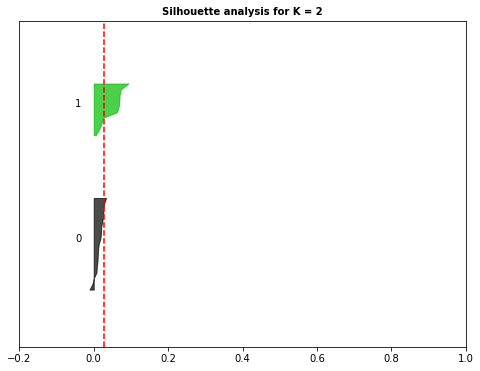

0.034694710824761534


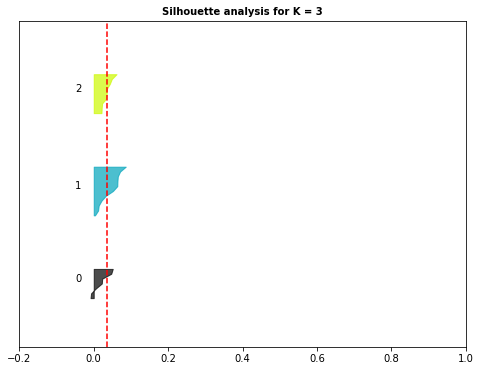

0.04071705934400564


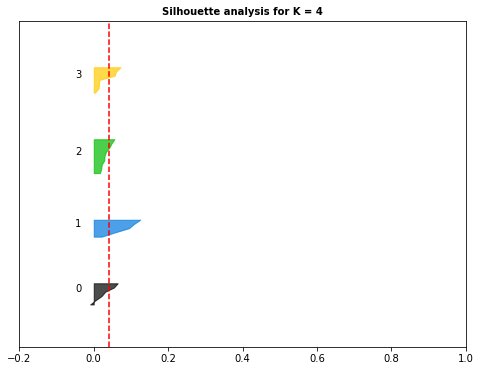

0.04191653777630778


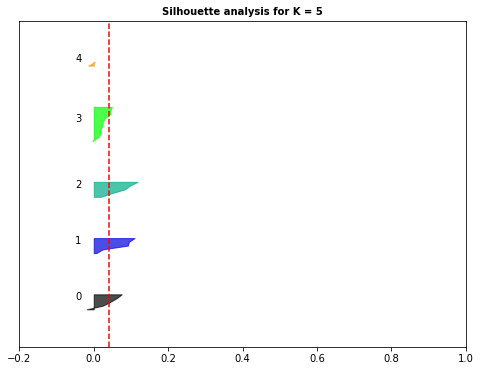

0.04769601157669258


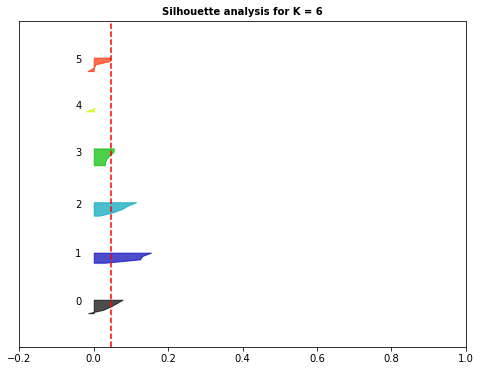

0.05059522041368444


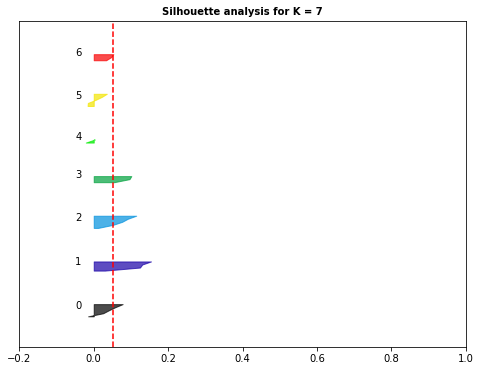

0.05425346768662526


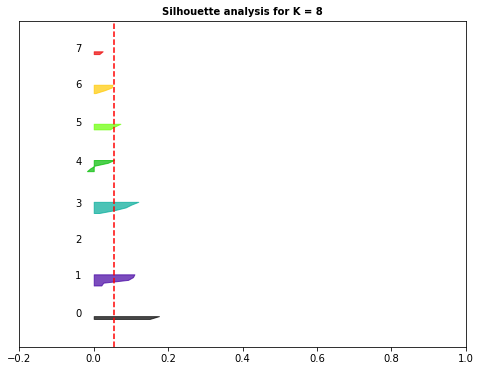

0.06007183943300617


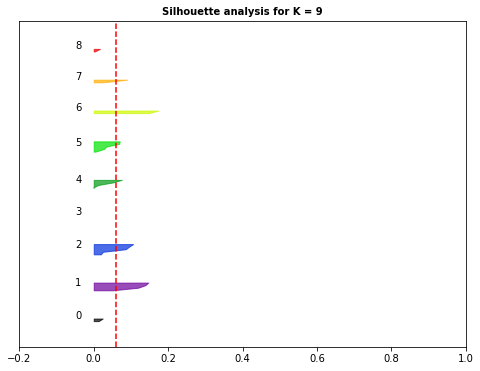

0.0625409232609775


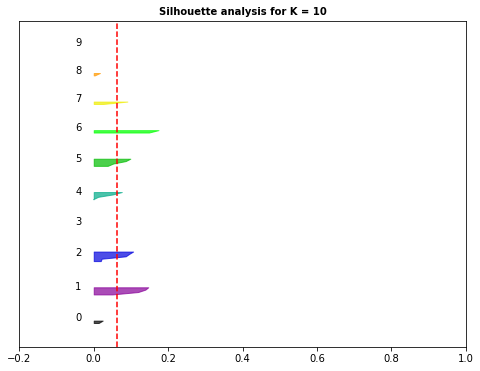

In [ ]:
# Running Kmeans
final_df = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())
max_k = 10
kmeans_results = run_KMeans(max_k, final_df)

# Plotting Silhouette Analysis
silhouette(kmeans_results, final_df, plot=True)

## Word Clouds

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

In [ ]:
kmeans = kmeans_results.get(3)
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)